# Detecting Fake News with Machine Learning

In [236]:
# notebook imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import zipfile
from nltk.corpus import stopwords 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

In [ ]:
# unzip file

zip_ref = zipfile.ZipFile('fake_real_news.zip', "r")
zip_ref.extractall()
zip_ref.close()

In [237]:
# get data
data = pd.read_csv('fake_real_news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [143]:
data['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

# Data Exploration and Preprocessing

In [238]:
# convert label to numbers

data.label.replace(to_replace=['FAKE', 'REAL'], value=[1, 0], inplace=True)

In [239]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [152]:
data['label'].value_counts()

0    3171
1    3164
Name: label, dtype: int64

In [50]:
# data exploration

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [6]:
data.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [9]:
data.all()

Unnamed: 0    True
title         True
text          True
label         True
dtype: bool

Text(0.5, 1.0, 'Class Distributions \n Real News     Fake News')

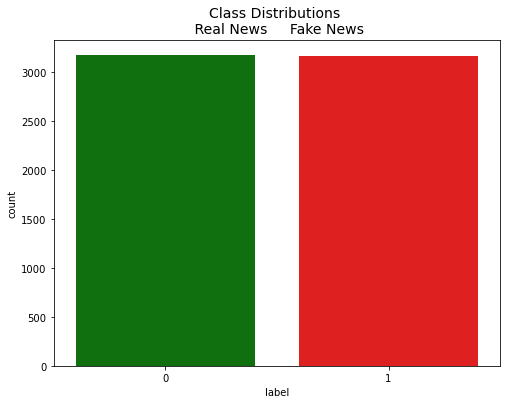

In [155]:
colors = ["green", "red"]

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette=colors)
plt.title('Class Distributions \n Real News     Fake News', fontsize=14, color='k')

In [240]:
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + 
            ' '.join(emoticons).replace('-', ''))
    return text

In [156]:
data.loc[1, 'text']

'Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home” ht

In [157]:
preprocessor(data.loc[1, 'text'])

'google pinterest digg linkedin reddit stumbleupon print delicious pocket tumblr there are two fundamental truths in this world paul ryan desperately wants to be president and paul ryan will never be president today proved it in a particularly staggering example of political cowardice paul ryan re re re reversed course and announced that he was back on the trump train after all this was an aboutface from where he was a few weeks ago he had previously declared he would not be supporting or defending trump after a tape was made public in which trump bragged about assaulting women suddenly ryan was appearing at a pro trump rally and boldly declaring that he already sent in his vote to make him president of the united states it was a surreal moment the figurehead of the republican party dosed himself in gasoline got up on a stage on a chilly afternoon in wisconsin and lit a match speakerryan says he voted for realdonaldtrump republicans it is time to come home https t co vytt49yvoe pic twi

In [241]:
# applying the preprocessor to out data

data['text'] = data['text'].apply(preprocessor)

In [242]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,daniel greenfield a shillman journalism fellow...,1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,u s secretary of state john f kerry said monda...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 the le...,1
4,875,The Battle of New York: Why This Primary Matters,it s primary day in new york and front runners...,0


In [243]:
stop = stopwords.words('english')
import re

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

In [244]:
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer
                        )

In [245]:
X, y = data.text, data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [161]:
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

C:\Users\Ben\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [26]:
# Processing texts (vectorization)

vectorizer = TfidfVectorizer(stop_words='english', max_df=.6)

vectorized_train = vectorizer.fit_transform(X_train)
vectorized_test = vectorizer.transform(X_test)

## PassiveAggressive Classifier

In [188]:
# building a clissifier

aggr_clf = PassiveAggressiveClassifier()
aggr_clf.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [189]:
aggr_clf.score(X_test, y_test)

0.9318181818181818

In [191]:
# evaluate the classifier
aggr_preds = aggr_clf.predict(X_test)
score = accuracy_score(y_test, aggr_preds)
print(f'Accuracy: {score*100:.2f}%')

Accuracy: 93.18%


In [196]:
print(f'Accuracy: {accuracy_score(y_test, aggr_preds)}')
print(f'Recall: {recall_score(y_test, aggr_preds)}')
print(f'Precision: {precision_score(y_test, aggr_preds)}')
print(f'F1_score: {f1_score(y_test, aggr_preds)}')

Accuracy: 0.9318181818181818
Recall: 0.9269521410579346
Precision: 0.9363867684478372
F1_score: 0.9316455696202532


<AxesSubplot:>

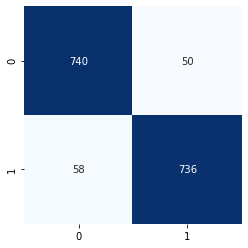

In [197]:
# confusion matrix

conf_mat = confusion_matrix(y_test, aggr_preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [252]:
# testing our model on real world test

label = {0:'Real News', 1:'Fake News'}

example = [data.iloc[2,:].text]

X = vect.transform(example)
print(f'Prediction: {label[aggr_clf.predict(X)[0]]}')

Prediction: Real News


# Training KNN model

In [200]:
# KNN
from sklearn.neighbors import KNeighborsClassifier as KNN

knn_clf = KNN()

knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [201]:
knn_preds = knn_clf.predict(X_test)

In [202]:
print(f'Accuracy: {knn_clf.score(X_test, y_test)}')

Accuracy: 0.6944444444444444


In [203]:
print(f'Accuracy: {accuracy_score(y_test, knn_preds)}')
print(f'Recall: {recall_score(y_test, knn_preds)}')
print(f'Precision: {precision_score(y_test, knn_preds)}')
print(f'F1_score: {f1_score(y_test, knn_preds)}')

Accuracy: 0.6944444444444444
Recall: 0.9722921914357683
Precision: 0.6256077795786061
F1_score: 0.7613412228796844


<AxesSubplot:>

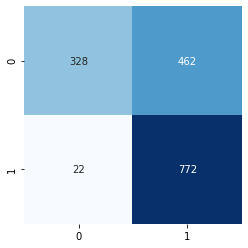

In [204]:
conf_mat = confusion_matrix(y_test, knn_preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [253]:
label = {0:'Real News', 1:'Fake News'}

example = [data.iloc[1,:].text]

X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[knn_clf.predict(X)[0]], 
       np.max(knn_clf.predict_proba(X))*100))

Prediction: Fake News
Probability: 80.00%


## SVM Model

In [207]:
from sklearn.svm import SVC
svm_clf = SVC()

svm_clf.fit(X_train, y_train)

SVC()

In [208]:
svm_preds = svm_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, svm_preds)}')
print(f'Recall: {recall_score(y_test, svm_preds)}')
print(f'Precision: {precision_score(y_test, svm_preds)}')
print(f'F1_score: {f1_score(y_test, svm_preds)}')

Accuracy: 0.9267676767676768
Recall: 0.9382871536523929
Precision: 0.9174876847290641
F1_score: 0.9277708592777086


<AxesSubplot:>

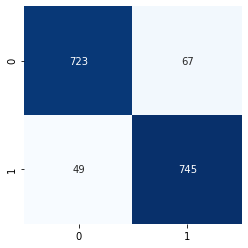

In [209]:
conf_mat = confusion_matrix(y_test, svm_preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [256]:
label = {0:'Real News', 1:'Fake News'}

# example = [data.iloc[4,:].text]
example = ['U.S. Secretary of State John F. Kerry said Monday']

X = vect.transform(example)
print(f'Prediction: {label[svm_clf.predict(X)[0]]}')

Prediction: Real News


## Decision Tree

In [220]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [221]:
tree_preds = tree_clf.predict(X_test)

In [222]:
print(f'Accuracy: {accuracy_score(y_test, tree_preds)}')
print(f'Recall: {recall_score(y_test, tree_preds)}')
print(f'Precision: {precision_score(y_test, tree_preds)}')
print(f'F1_score: {f1_score(y_test, tree_preds)}')

Accuracy: 0.8320707070707071
Recall: 0.8513853904282116
Precision: 0.8203883495145631
F1_score: 0.8355995055624228


<AxesSubplot:>

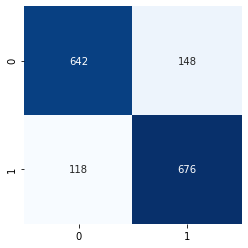

In [223]:
conf_mat = confusion_matrix(y_test, tree_preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [257]:
label = {0:'Real News', 1:'Fake News'}

example = [data.iloc[10,:].text]

X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[tree_clf.predict(X)[0]], 
       np.max(tree_clf.predict_proba(X))*100))

Prediction: Real News
Probability: 100.00%


In [231]:
model_results = pd.DataFrame([['PassiveAggressive',
                               accuracy_score(y_test, aggr_preds),
                               recall_score(y_test, aggr_preds),
                               precision_score(y_test, aggr_preds),
                               f1_score(y_test, aggr_preds)],
                             ['KNN',
                               accuracy_score(y_test, knn_preds),
                               recall_score(y_test, knn_preds),
                               precision_score(y_test, knn_preds),
                               f1_score(y_test, knn_preds)],
                             ['SVM',
                               accuracy_score(y_test, svm_preds),
                               recall_score(y_test, svm_preds),
                               precision_score(y_test, svm_preds),
                               f1_score(y_test, svm_preds)],
                             ['Decision Tree',
                               accuracy_score(y_test, tree_preds),
                               recall_score(y_test, tree_preds),
                               precision_score(y_test, tree_preds),
                               f1_score(y_test, tree_preds)]],
                             
               columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])

In [246]:
# model comparison

model_results

,Model,Accuracy,Recall,Precision,F1 Score
0,PassiveAggressive,0.931818,0.926952,0.936387,0.931646
1,KNN,0.694444,0.972292,0.625608,0.761341
2,SVM,0.926768,0.938287,0.917488,0.927771
3,Decision Tree,0.832071,0.851385,0.820388,0.835600
